In [3]:
import os
os.getcwd()
import sys
sys.path.append('/Users/juncheng/PycharmProjects/test') 
import matplotlib.pyplot as mpl
import numpy as np
import modelBuilder
import models
import time
import jax

In [4]:
# Initialize the model and compile it for JAX
def InitialiseModel(ParamArray,runTime,totalRuns,t0 = time.time()):
    # initialiseModel(lung,heart,gasExchange,nrLevels)
    # lung,heart,gasExchange  --> True or False to enable the parts of the model
    # nrLevels                --> 1 (Basic Model) or 2 or 5 (trees with 2 or 5 generations)
    model = modelBuilder.ModelStructure(True,False ,False,1,ParamArray)


    # Get the maps of the equations and the parameters of the model for the solver
    states, capacitorObjects, resistorObjects, connectionbjects, dVdt, capacitors, flows, resistors, pressures = model.getEquationMaps()

    # Create the model object with the parameters and the equations to be solved by JAX
    cpModel = models.CardioPulmonaryModel(capacitorObjects, resistorObjects, connectionbjects, states)

    t1 = time.time()
    print(str(np.round(t1 - t0, 4)) + ' -> Model Initialised!')
    
    # First run to compile the model
    res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,states)
    print(str(np.round(time.time() - t1, 4)) + ' -> Compiled!')
    t1 = time.time()

    

    newStates = {key: float(y_dense[key][-1]) for key in states.keys()}
    res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,newStates)
    pressureRes = {key: np.array(value) for key, value in out.items()}
    results = {
        #'I_Lu|0': pressureRes['I_Lu|0'],
        #'I_Lu|0|0': pressureRes['I_Lu|0|0'], 
        'I_Lu|0|0|0': pressureRes['I_Lu|0|0|0']
        }

    

    return cpModel, newStates, results, t1

In [5]:
def RunModel(cpModel, states ,ParamArray,runTime,totalRuns,t1 = time.time()):
    # initialiseModel(lung,heart,gasExchange,nrLevels)
    # lung,heart,gasExchange  --> True or False to enable the parts of the model
    # nrLevels                --> 1 (Basic Model) or 2 or 5 (trees with 2 or 5 generations)
    # ParamArray              --> Array with the parameters of the model
    t1 = time.time()

    jax.config.update("jax_enable_x64", True)

    states['R_Lu|0'] = ParamArray[0]
    states['R_Lu|0|0'] = ParamArray[1]
    states['R_Lu|0|0|0'] = ParamArray[2]
    states['C_Lu|0'] = ParamArray[3]
    states['C_Lu|0|0'] = ParamArray[4]
    states['C_Lu|0|0|0'] = ParamArray[5]

    for nruns in range(totalRuns):

        # Run the model with the updated states
        res, t_dense, y_dense, deriv, out = models.solveModel(cpModel,runTime,states)

        # Concatenate the results of the runs to the previous results
        pressureRes = {key:  np.array(value) for key, value in out.items()}  
        runsRes = {key: np.array(value) for key, value in y_dense.items()} 
            
        #print(str(np.round(time.time() - t1, 4)) + ' -> Run:' + str(nruns) + ' of ' + str(totalRuns-1) + ' completed!')


    return pressureRes['I_Lu|0|0|0']

In [6]:
runTime = 6.0
totalRuns = 1
totalTime = runTime*totalRuns

# Create the time vector
t = np.arange(0, totalTime + totalRuns*0.01 , 0.01)


# Here is where you define the values for the parameters
#ParamArray = ['R_Lu|0','R_Lu|0|0', 'R_Lu|0|0|0', 'C_Lu|0', 'C_Lu|0|0', 'C_Lu|0|0|0']
ParamArray = [0.01,0.03,0.02,2.4,3,100]
# with initial conditions -> [0.001,0.002,0.003,2.4,3,100,28,36,1400]

#with jax.default_device(jax.devices("gpu")[0]):
jax.config.update("jax_enable_x64", True)
# This function takes those parameters and runs the model
model,states,runRes, t1 = InitialiseModel(ParamArray,runTime,totalRuns,t0 = time.time())
# runRes is a dictionary with keys(['I_Lu|0', 'I_Lu|0|0', 'I_Lu|0|0|0'])
# The time series is the alue of the key

print(runRes.keys())

Simple Lung initialised
0.0014 -> Model Initialised!
1.6418 -> Compiled!
dict_keys(['I_Lu|0|0|0'])


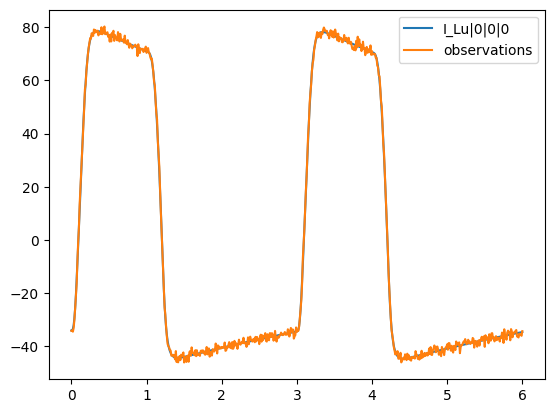

In [7]:
# Print results of the simulation and plot them
# Observations are the results of the simulation with noise added
for key,results in runRes.items():
    obs = np.array(results)+ np.random.normal(0,0.5,results.shape)+np.random.normal(0,1,results.shape)
    mpl.plot(np.array(t),np.array(results), label = key)
    mpl.plot(np.array(t),np.array(obs), label = 'observations')
    mpl.legend()
    mpl.show()


In [8]:
import functools as ft
import math as math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy
import matplotlib.cm as cm

Since all parameters are positive and the ODEsolver in $InitialiseModel\& RunModel$ would break if the potentional parameters are far away from their corresponding true values, we did the following transformation:
\begin{equation}
    Para = (\exp{(x_1/50)},\exp{(x_2/50)},\exp{(x_3/50)},\exp{(x_4)},\exp{(x_5)},\exp{(x_6*50)}),
\end{equation}
where $X=[x_1,x_2,\ldots,x_6]\sim \mathcal{N}(0,\mathbf{I}_{6})$.

In [9]:
# Function to run the model given an input parameter array
def lung1(model,states,x,t1):
    runTime = 6.0
    totalRuns = 1
    para =[math.exp(x[0])/50,math.exp(x[1])/50,math.exp(x[2])/50,math.exp(x[3]),math.exp(x[4]),math.exp(x[5])*50]
    #[math.exp(x[0])/500,0.002,math.exp(x[1])/500,2.4,3,100]
    runRes = RunModel(model,states,para,runTime,totalRuns,t1)
    return(runRes)

Since the initial condition of $InitialiseModel$ is the true value of the parameters of interest whereas $RunModel$'s initial condition depends on our random sample, we discarded the estimated flows from time 0 to time 3 and only chose the estimated flows between time 3 to time 6.
From time 3 to time 6, we got the 300 observations at fixed time points denoted by $z = [z_{301},\ldots,z_{600}]$ and have
\begin{align}
    z_{301} &= \eta(x)_{301} + \epsilon_{me,301}+\epsilon_{md,301},\\
    &\ldots \\
    z_{600} &= \eta(x)_{600} + \epsilon_{me,600}+\epsilon_{md,600},
\end{align}
where $\eta(x)_{i}$, $\epsilon_{me,i}\sim \mathcal{N}(0, \sigma_{me})$ and $\epsilon_{md,i} \sim \mathcal{N}(0, \sigma_{md})$ are the estimated flow, measurement error and modal discrepancy at time $\frac{i}{100}$, respectively. Assume all error terms are independent, we have
\begin{equation}
    (z_{i}-\eta(x)_{i}) \overset{\mathrm{iid}}{\sim} \mathcal{N}(0,\sigma_{me}+\sigma_{md}) \Rightarrow 
    Z_i = \frac{z_{i}-\eta(x)_{i}}{ \sqrt{\sigma_{me}+\sigma_{md}}} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0,1)
\end{equation}
and then 
\begin{equation}
    \sum_{i=301}^{600} Z_i^2 \sim \chi^2 (600-301) \Rightarrow \frac{\sum_{i=301}^{600} Z_i^2 - 300} {\sqrt{2*300}} \overset{d}{\rightarrow} \mathcal{N}(0,1)
\end{equation}
since $k>>50$.


In [10]:
## Implausibility measure
md=1**2 # model discrepancy
me=0.5**2 # measurement error
idxToIgnore = 300
def Imp(obs,x,model,states,t1,me,md):
    m = np.array(lung1(model,states,x,t1))
    N = obs.shape[0]
    #I = abs((sum((np.array(obs[idxToIgnore:idxToIgnore+100])-np.array(m[idxToIgnore:idxToIgnore+100]))**2)/(me+md))-100)/math.sqrt(2*(100))
    I = abs((sum((np.array(obs[idxToIgnore:])-np.array(m[idxToIgnore:]))**2)/(me+md))-N+idxToIgnore)/math.sqrt(2*(N-idxToIgnore))
    return(I)


Implausibility measure: true value of the parameters
0.20286522018722097
Implausibility measure: one of random samples:
92644.843799518
Implausibility measure: mean of random samples:
34682.66372852809


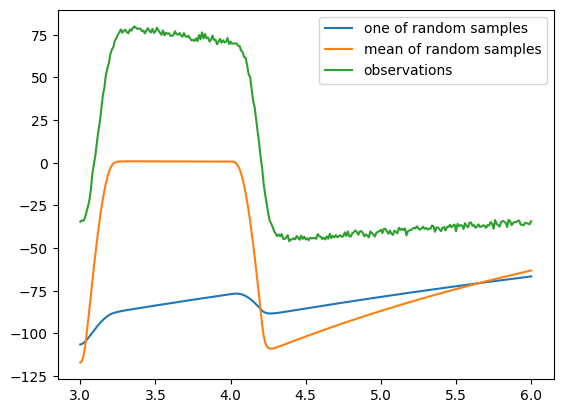

In [11]:
print('Implausibility measure: true value of the parameters')
print(Imp(obs,[math.log(0.01*50),math.log(0.03*50),math.log(0.02*50),math.log(2.4),math.log(3),math.log(100/50)],model,states,t1,md=md,me=me))

samples = np.random.randn(500,6)
result = np.concatenate((np.exp(np.random.randn(500,3))/50,np.exp(np.random.randn(500,2)),\
                         np.exp(np.random.randn(500,1))*50),axis=1)
values = samples[0,:]
mean = np.mean(samples,0)

print('Implausibility measure: one of random samples:')
print(Imp(obs,values,model,states,t1,md,me))
print('Implausibility measure: mean of random samples:')
print(Imp(obs,mean,model,states,t1,md,me))

###compare esitmated flows & the observations
mpl.plot(np.array(t[idxToIgnore:]),np.array(lung1(model,states,values,t1))[idxToIgnore:], label = 'one of random samples')
mpl.plot(np.array(t[idxToIgnore:]),np.array(lung1(model,states,mean,t1))[idxToIgnore:], label = 'mean of random samples')
mpl.plot(np.array(t[idxToIgnore:]),np.array(obs)[idxToIgnore:], label = 'observations')
mpl.legend()
mpl.show()

In [19]:
#Subset Simulation for history matching
#algorithm we use to update samples, and we here consider Modified Metropolis
###modified metropolis
def modmetro(nc,ns,d,z,q,Y,L,model,states,t1):
    for j in range(1,nc+1):
        for m in range(1,ns+1):
            ### step 1
            for k in range(1,d+1):
                a = z[j-1,k-1,m-1]+np.random.randn(1)/math.sqrt(L)
                r = min(1, norm.pdf(a)/norm.pdf(z[j-1,k-1,m-1]))
                if np.random.rand(1)<r:
                    q[k-1]=a
                else:
                    q[k-1]=z[j-1,k-1,m-1]
            ###step 2 q belongs to F_L or not
            if Imp(obs=obs,x=q,model=model,states=states,t1=t1,me=me,md=md)<Y: ###responses
                z[j-1,:,m]=q
            else:
                z[j-1,:,m]=z[j-1,:,m-1]
    return(z)

def sus(obs,n,model,states,t1,me,md):
    d = 6 #dimension of the input space first layer concludes 2 parameters?
    YF = 3 #critical threshold (gx>=YF)
    n = n #3000 #number of samples per level
    p = 0.1 #level probability
    nc = int(n*p) #number of Markov chains
    ns = int((1-p)/p) #number of states in each chain
    L = 0 # zero level
    Lmax = 100 # define the possible maximum of number of levels
    Xs = np.zeros((n,d,Lmax)) #samples for different levels
    xs = np.random.randn(n,d) # Monte Carlo samples(initial space filling samples)
    Xs[:,:,0] = xs ### samples for zero level
    nF = np.zeros(Lmax) # number of failure samples
    ys = np.zeros((Lmax,n)) # responses
    zs = np.zeros((nc,d,ns+1)) # seeds
    Ys = np.zeros(Lmax)# intermediate threshold
    qs = np.zeros(d)## potential next state in Markov chain?
    index = [0]
    sigma = 6/math.sqrt(d) ###intitial variance 
    for i in range(1, n+1):
        ys[0,i-1] = Imp(obs=obs,x=Xs[i-1,:,L],model=model,states=states,t1=t1,me=me,md=md) 
        if ys[0,i-1]<YF: # whether it falls in failure domain
            nF[0]=nF[0]+1
            index.append(i-1)       
    while (nF[L]/n)<p and (L<=51): # stopping criterion
        index = [0]
        L=L+1 # next conditional level is needed
        w = ys[L-1,:]
        ind = sorted(range(len(w)), key=lambda k: w[k])# original index of descending responses
        ys[L-1,:] = ys[L-1,ind] #renumbered responses
        Xs[:,:, L-1] = Xs[ind,:,L-1] # renumbered samples
        Ys[L-1] = (ys[L-1,nc-1]+ys[L-1,nc])/2 #L^th intermediate threshold
        zs[:,:,0] = Xs[range(0,nc),:, L-1] # seeds of Markov chain
        print('L = ', L)
        print('intermediate threshold:',Ys[L-1])
        zs = modmetro(nc,ns,d,z=zs,q=qs,Y=Ys[L-1],L=L,model=model,states=states,t1=t1)###modified metropolis algorithm
        for j in range(1,nc+1):
            for m in range(1,ns+2):
                Xs[(j-1)*(ns+1)+m-1,:,L]=zs[j-1,:,m-1]### update L-th level samples
        zs = np.zeros((nc,d,ns+1))
        for i in range(1,n+1):
            ys[L, i-1] = Imp(obs=obs,x=Xs[i-1,:,L],model=model,states=states,t1=t1,me=me,md=md)
            if ys[L, i-1]<YF:
                nF[L]=nF[L]+1
                index.append(i-1)
    return(Xs[:,:,L])
    #Xfin = Xs[index[1:],:,L]
    #return(Xfin)



In [20]:
# history matching
start_time = time.time()
N=100
X=sus(obs=obs,n=N,model=model,states=states,t1=t1,me=me,md=md)#new particles obtained from SuS
y = np.zeros(X.shape[0])
for i in range(1,X.shape[0]+1):
    y[i-1] = Imp(obs=obs,x=X[i-1,:],model=model,states=states,t1=t1,me=me,md=md)
print("--- %s seconds ---" % (time.time() - start_time))

L =  1
intermediate threshold: 7643.444503923052
L =  2
intermediate threshold: 1169.8802165857169
L =  3
intermediate threshold: 764.8863788913611
L =  4
intermediate threshold: 420.0453211903083
L =  5
intermediate threshold: 318.6583955506197
L =  6
intermediate threshold: 83.5410932582744
L =  7
intermediate threshold: 47.429310144638976
L =  8
intermediate threshold: 47.429310144638976
L =  9
intermediate threshold: 47.429310144638976
L =  10
intermediate threshold: 32.62703122086029
L =  11
intermediate threshold: 31.795739839988325
L =  12
intermediate threshold: 29.230659667682563
L =  13
intermediate threshold: 29.230659667682563
L =  14
intermediate threshold: 29.230659667682563
L =  15
intermediate threshold: 29.230659667682563
L =  16
intermediate threshold: 29.230659667682563
L =  17
intermediate threshold: 10.337567669849124
L =  18
intermediate threshold: 10.337567669849124
L =  19
intermediate threshold: 10.337567669849124
L =  20
intermediate threshold: 10.337567669849

Estimated flows obtained from history matching:

[0.03248622 0.01366103 0.01300901] [2.11794077 2.8118246 ] 100.14858034828502
3.1654553888398116


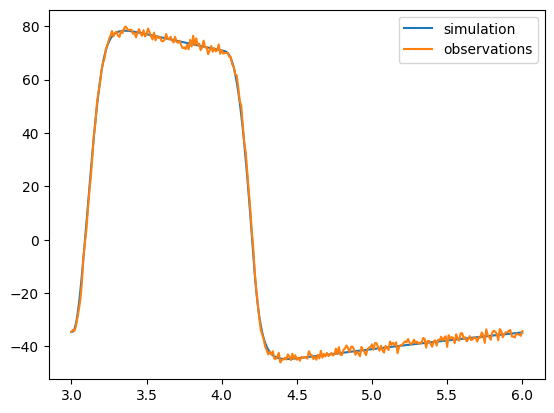

In [21]:
mean = np.mean(X,0)
print(np.exp(mean[0:3])/50,np.exp(mean[3:5]),np.exp(mean[5])*50)
print(Imp(obs,mean,model,states,t1,me=me,md=md))

t = np.array(t)
simulation = np.array(lung1(model,states,mean,t1))
observations = np.array(obs)

mpl.plot(t[idxToIgnore:],simulation[idxToIgnore:], label = 'simulation')
#mpl.plot(np.array(t),np.array(lung(mean)), label = 'mean of initial random samples')
mpl.plot(t[idxToIgnore:],observations[idxToIgnore:], label = 'observations')
mpl.legend()
mpl.show()
#ParamArray = [0.001,0.002,0.003,2.4,3,100]

History Matching only detects the high probability regions but does not distinguish the samples, also known as particles, in such regions, however, the particles whose implausibility measure is lower is closer to the true value and should be given more weights if we are intersted in the distribution of parameters. To do so, we considered performing Sequential Monte Carlo for the particles obtained from history matching.

In [22]:
###SMC subset simulation 

def smcsus(obs,model,states,t1,me,md,X):
    d = 6 #1000 #dimension of the input space 
    n = X.shape[0] #3000 #number of samples per level
    L = 0 # zero level
    Nthre = 0.2*n ##ESS threshold
    thre = 1###stopping rule for bisection
    Lmax = 100 # define the possible maximum of number of levels
    Xs = np.zeros((n,d,Lmax)) #samples for different levels
    phi= np.zeros(Lmax)
    xs = X #np.random.uniform(-0.5,0.5,size = (n,d)) # Monte Carlo samples(initial space filling samples)
    Xs[:,:,0] = xs ### samples for zero level
    zs = np.zeros((n,d))###resampling
    q = np.zeros((Lmax,n))  ###normalised weight
    sigma = np.repeat(1e-04,d)
    
    while phi[L]<1: # stopping criterion
        ###specify the next tempering hyperparameter phi[L+1]
        ##iterative bisection method to solve ESS approx N_thresh = alpha* N
        a = phi[L]
        b = 1
        for k in range(n):
            q[L+1,k] = norm.pdf(Imp(obs,Xs[k,:,L],model,states,t1,me=me,md=md), loc = 0, scale = 1)**(b-phi[L])
        if sum(q[L+1,:])!= 0:
            q[L+1,:]=q[L+1,:]/sum(q[L+1,:])
            ESS = 1/sum(q[L+1,:]**2)
        else:
            ESS= 0
         
        if ESS > Nthre:
            phi[L+1] = 1
            print('phi=',phi[L+1])
            print('ESS',ESS)  
        else:
            while abs(ESS-Nthre)>thre:
                c = (a+b)/2
                #print('c=',c)
                for k in range(n):
                    q[L+1,k] = norm.pdf(Imp(obs,Xs[k,:,L],model,states,t1,me=me,md=md), loc = 0, scale = 1)**(c-phi[L])
                if sum(q[L+1,:])!= 0:
                    q[L+1,:]=q[L+1,:]/sum(q[L+1,:])
                    ESS = 1/sum(q[L+1,:]**2)
                else:
                    ESS = 0
                if ESS<Nthre:
                    b = c
                else:
                    a = c
            phi[L+1] = c
            print('phi=', phi[L+1])
            print('ESS',ESS)
            

        L += 1###increment
        Xs[:,:,L] = Xs[:,:,L-1]
        ###reweight
        probs = q[L,:].tolist()
        ### resample
        zs[:,:] =  Xs[:,:,L] 
        for j in range(1, n + 1):
            thre = np.random.uniform(0, 1)
            bb = q[L, j - 1]/max(q[L,:])
            if thre >= bb:
                A = np.random.multinomial(1, probs)
                A = A.tolist()
                A = A.index(1)
                Xs[j-1, :,L] = zs[A, :]
        ###mcmc move
        for s in range(1,10+1):##10+1
            acc = 0
            for k in range(1,n+1):
                zpot = Xs[k-1,:,L]+multivariate_normal.rvs(mean=np.repeat(0,d), cov=np.diag(sigma))
                alpha = norm.pdf(Imp(obs,zpot,model,states,t1,me=me,md=md), loc = 0, scale = 1)**(phi[L])
                alpha = alpha/(norm.pdf(Imp(obs,Xs[k-1,:,L],model,states,t1,me=me,md=md), loc = 0, scale = 1))**(phi[L])
                if np.random.uniform(0,1) <= alpha:
                    Xs[k-1,:,L]=zpot
                    acc+=1
            print(acc)
            if acc/n<=0.3:
                sigma = np.exp(np.log(sigma) - np.repeat(np.log(d)/s,d))
            else:
                sigma = np.exp(np.log(sigma) + np.repeat(np.log(d)/s,d))
            print(sigma)
    return(Xs[:,:,L])



In [23]:
X=smcsus(obs=obs,model=model,states=states,t1=t1,me=me,md=md,X=X)

phi= 1.0
ESS 95.98452407895351
1
[1.66666667e-05 1.66666667e-05 1.66666667e-05 1.66666667e-05
 1.66666667e-05 1.66666667e-05]
26
[6.80413817e-06 6.80413817e-06 6.80413817e-06 6.80413817e-06
 6.80413817e-06 6.80413817e-06]
39
[1.23639396e-05 1.23639396e-05 1.23639396e-05 1.23639396e-05
 1.23639396e-05 1.23639396e-05]
32
[1.93506112e-05 1.93506112e-05 1.93506112e-05 1.93506112e-05
 1.93506112e-05 1.93506112e-05]
16
[1.35227319e-05 1.35227319e-05 1.35227319e-05 1.35227319e-05
 1.35227319e-05 1.35227319e-05]
20
[1.00316544e-05 1.00316544e-05 1.00316544e-05 1.00316544e-05
 1.00316544e-05 1.00316544e-05]
32
[1.29579717e-05 1.29579717e-05 1.29579717e-05 1.29579717e-05
 1.29579717e-05 1.29579717e-05]
27
[1.03578143e-05 1.03578143e-05 1.03578143e-05 1.03578143e-05
 1.03578143e-05 1.03578143e-05]
29
[8.4880293e-06 8.4880293e-06 8.4880293e-06 8.4880293e-06 8.4880293e-06
 8.4880293e-06]
32
[1.01536455e-05 1.01536455e-05 1.01536455e-05 1.01536455e-05
 1.01536455e-05 1.01536455e-05]


[0.03255447 0.01369045 0.0130202 ] [2.11529723 2.81957266] 100.1917380180299
2.929710023350745


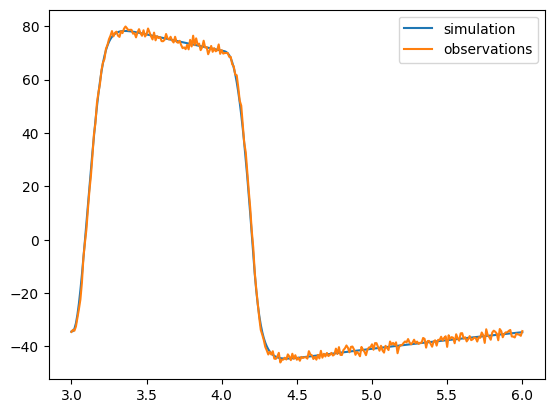

In [24]:
mean = np.mean(X,0)
print(np.exp(mean[0:3])/50,np.exp(mean[3:5]),np.exp(mean[5])*50)
print(Imp(obs,mean,model,states,t1,me=me,md=md))

t = np.array(t)
simulation = np.array(lung1(model,states,mean,t1))
observations = np.array(obs)

mpl.plot(t[idxToIgnore:],simulation[idxToIgnore:], label = 'simulation')
#mpl.plot(np.array(t),np.array(lung(mean)), label = 'mean of initial random samples')
mpl.plot(t[idxToIgnore:],observations[idxToIgnore:], label = 'observations')
mpl.legend()
mpl.show()

SMC improved the accuracy

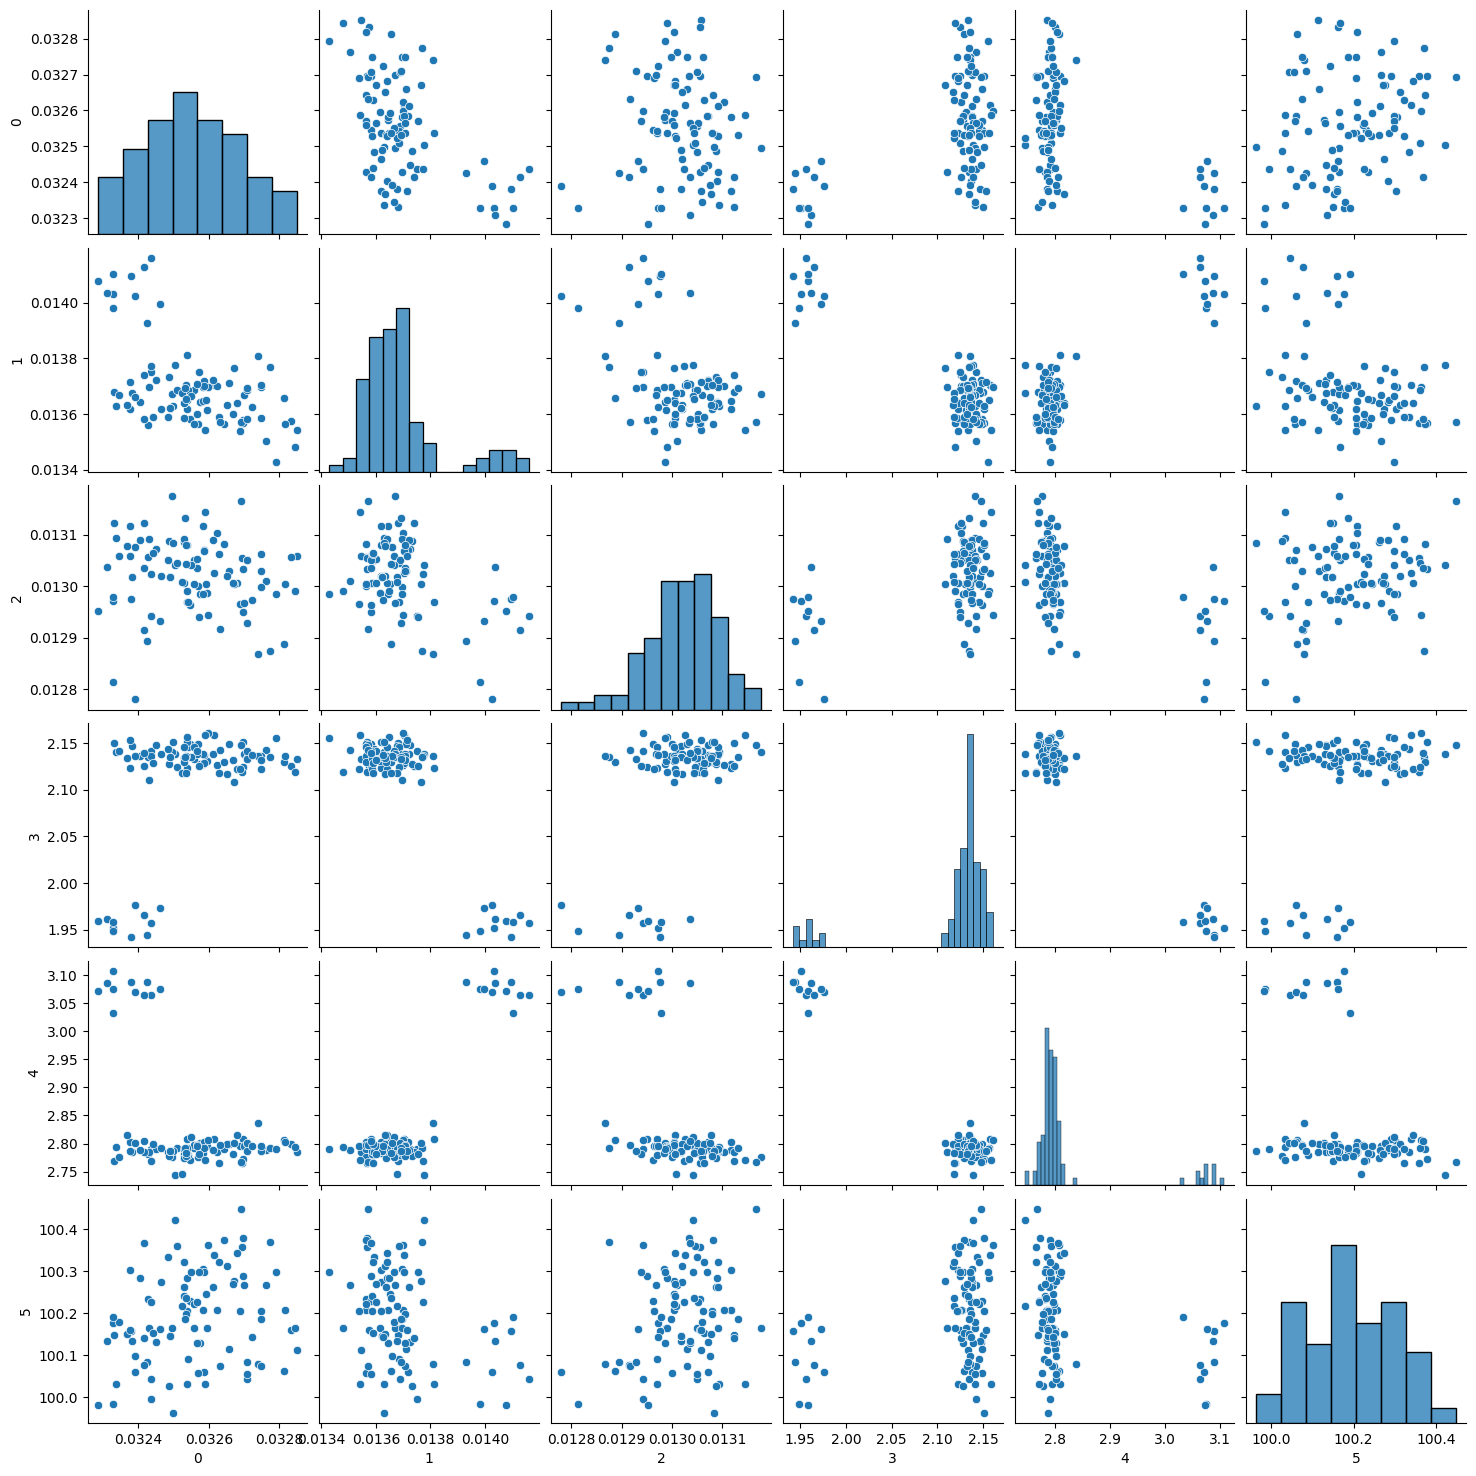

In [25]:
import seaborn as sns
import pandas as pd
A = np.empty(shape = X.shape)
A[:,0:3] = np.exp(X[:,0:3])/50
A[:,3:5] = np.exp(X[:,3:5])
A[:,5] = np.exp(X[:,5])*50
sns.pairplot(pd.DataFrame(A))

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(init="random", n_clusters=2)
kmeans.fit(X)

KMeans(init='random', n_clusters=2)

In [38]:
#raw mean
rm = kmeans.cluster_centers_
#mean of each modes
print(np.exp(rm[0,0:3])/50,np.exp(rm[0,3:5]),np.exp(rm[0,5])*50)
print(np.exp(rm[1,0:3])/50,np.exp(rm[1,3:5]),np.exp(rm[1,5])*50)

[0.03237144 0.01405168 0.01292624] [1.95790432 3.07445807] 100.0961838033267
[0.03257716 0.01364645 0.01303186] [2.13560894 2.78957421] 100.20355442155181
